In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn 
import scipy.signal as signal


# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(torch.cuda.is_available())
device = torch.device("cpu")

# Close all open plots
plt.close('all')

In [3]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_.mat')
data_out = scipy.io.loadmat(filepath)


# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size


In [4]:
# Create time vector
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 3)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 2

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        )    
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))            # to smooth the input signal of Qhot (noisy)

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [5]:
#Set dimensions for RNN layers
idd = u[0,:,:].shape[1] #3
hdd = 150 #7 /10
ldd = 1 #2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
LTS = LSTModel(idd, hdd, ldd, odd)

# Load the model parameters before starting a new training session
#LTS.load_state_dict(torch.load('parameters_LSTM_direct.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 300

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [6]:
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yLTS = LTS(u)
    yLTS = torch.squeeze(yLTS)
    

    # Calculate loss and backpropagate
    loss = MSE(yLTS, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(LTS.state_dict(), f'parameters_LSTM_direct.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")

Epoch: 1 	||	 Loss: 0.48523902893066406
Epoch: 2 	||	 Loss: 0.22722798585891724
Epoch: 3 	||	 Loss: 1.889592170715332
Epoch: 4 	||	 Loss: 0.1058209240436554
Epoch: 5 	||	 Loss: 0.1986549198627472
Epoch: 6 	||	 Loss: 0.21871483325958252
Epoch: 7 	||	 Loss: 0.2020159512758255
Epoch: 8 	||	 Loss: 0.15138252079486847
Epoch: 9 	||	 Loss: 0.06087550148367882
Epoch: 10 	||	 Loss: 0.021273186430335045
Epoch: 11 	||	 Loss: 0.04054548591375351
Epoch: 12 	||	 Loss: 0.012099198997020721
Epoch: 13 	||	 Loss: 0.009506970643997192
Epoch: 14 	||	 Loss: 0.01634778082370758
Epoch: 15 	||	 Loss: 0.020549900829792023
Model parameters saved at epoch 15
Epoch: 16 	||	 Loss: 0.019874287769198418
Epoch: 17 	||	 Loss: 0.01555983629077673
Epoch: 18 	||	 Loss: 0.010068554431200027
Epoch: 19 	||	 Loss: 0.006124455481767654
Epoch: 20 	||	 Loss: 0.005540546961128712
Epoch: 21 	||	 Loss: 0.007860285229980946
Epoch: 22 	||	 Loss: 0.01034027524292469
Epoch: 23 	||	 Loss: 0.010427139699459076
Epoch: 24 	||	 Loss: 0.008

In [7]:
# Save the model parameters after training
#torch.save(LTS.state_dict(), 'LSTM_parameters.pth')

In [8]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 3)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot_val[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        ) 
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
yLTS_val = LTS(uval)
#yLTS_val = yLTS_val.unsqueeze_(0)
print(uval)
# Calculate loss for validation data
loss_val = MSE(yLTS_val, yval)

tensor([[[0.0000, 0.6328, 0.2772],
         [0.0000, 0.6569, 0.2770],
         [0.0000, 0.6623, 0.2768],
         ...,
         [0.0000, 0.6250, 0.2363],
         [0.0000, 0.6325, 0.2379],
         [0.0000, 0.5539, 0.2368]]])


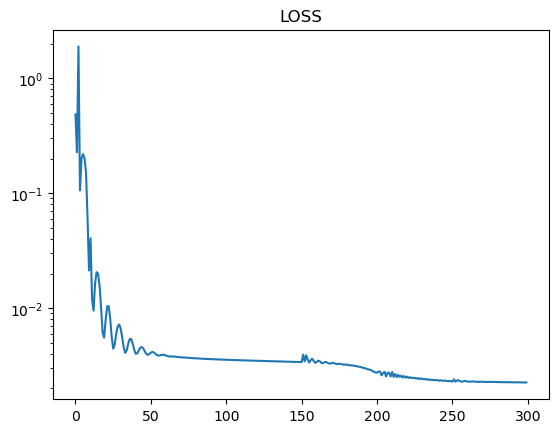

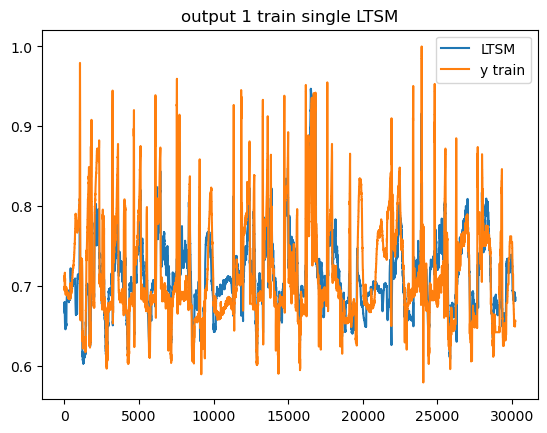

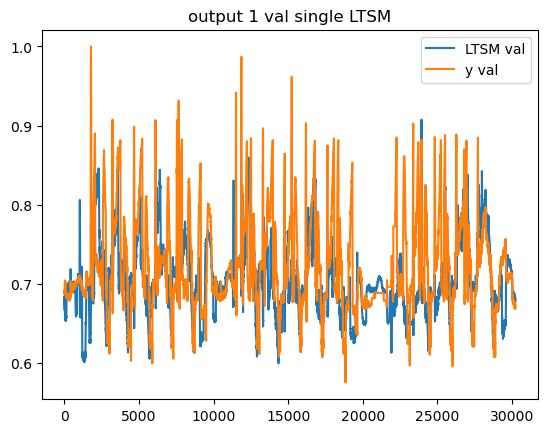

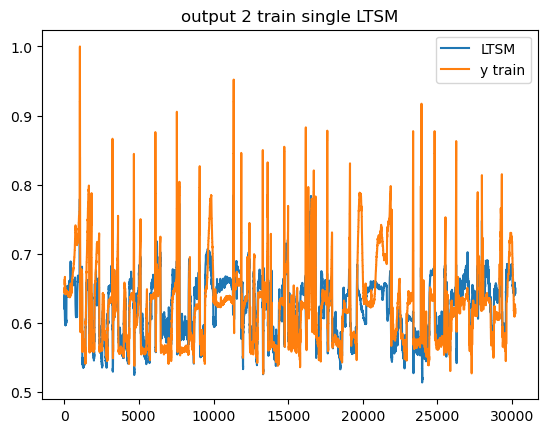

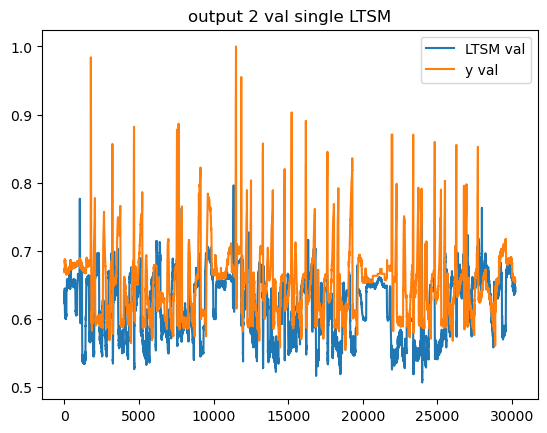

Loss Validation single LTSM: 0.004872474353760481


In [9]:
# Plot loss over epochs
plt.figure('8')
plt.semilogy(LOSS)
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yLTS[0, 10:, 0].detach().numpy(), label='LTSM')
plt.plot(y[0, 10:, 0].detach().numpy(), label='y train')
plt.title("output 1 train single LTSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yLTS_val[0, 10:, 0].detach().numpy(), label='LTSM val')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y val')
plt.title("output 1 val single LTSM")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yLTS[0, 10:, 1].detach().numpy(), label='LTSM')
plt.plot(y[0, 10:, 1].detach().numpy(), label='y train')
plt.title("output 2 train single LTSM")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yLTS_val[0,10:, 1].detach().numpy(), label='LTSM val')
plt.plot(yval[0, 10:, 1].detach().numpy(), label='y val')
plt.title("output 2 val single LTSM")
plt.legend()
plt.show()

# Save RNN output and validation data to file
scipy.io.savemat('data_singleRNN_sysID_LTSM.mat', dict(yLTSm_val=yLTS_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single LTSM: {loss_val}")